# 1.导入数据集

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
DATA_URL = "./Dataset/Kaggle/"

data_train = pd.read_csv(DATA_URL+"train.csv")
data_test = pd.read_csv(DATA_URL+"test.csv")

print(data_train.shape)
print(data_test.shape)

(1460, 81)
(1459, 80)


# 2.数据预处理

对所有非对象类型的数据标准化，并填补缺失值

数据标准化：

$$
    x_i = \frac{x_i - \mu}{\sigma}
$$

标准化后数据的均值为0

对所有对象类型转换为离散值：举个例⼦，假设特征MSZoning⾥⾯有两个不同的离散值RL和RM，那么这⼀步转换将**去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM**，其值为0或1。如果⼀个样本原来在MSZoning⾥的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0（有n个取值，就变为n个特征项）。

In [4]:
'''
    输入: DataFrame
    输出: 标准化、特征项拓展后的DataFrame
'''
def normalize(input):
    print(input.shape)
    # 找到所有非对象类型的数据对应的索引(除外)
    data = input
    numeric_index = data.dtypes[data.dtypes != 'object'].index
    
    # 对上述索引对应的值进行标准化计算
    data[numeric_index] = data[numeric_index].apply(
        lambda x: (x-x.mean()) / x.std()
    )

    # 对为NA的地方用均值0填充
    data[numeric_index] = data[numeric_index].fillna(0)

    # 处理对象类型数据项
    # get_dummies函数只会处理非数值类型
    data = pd.get_dummies(data, dummy_na=True)  # NA也作为一个特征项
    print(data.shape)

    return data

all_features = pd.concat((data_train.iloc[:,1:-1], data_test.iloc[:,1:]))
all_features = normalize(all_features)

# 获取训练数据条数
n_train = data_train.shape[0]

# 获取训练特征（values属性获取ndarray数组）
train_features = torch.tensor(all_features.iloc[:n_train].values.astype(np.float32))                    # (1460, 330)

# 获取训练标签
train_labels = torch.tensor(data_train.SalePrice.values.astype(np.float32)).reshape(-1,1)              # (1460, 1)

# 获取测试特征
test_features = torch.tensor(all_features.iloc[n_train:].values.astype(np.float32))      # (1459, 330)

(2919, 79)
(2919, 330)


- Series：一维、可进行矢量运算、索引可重复的字典
- DataFrame：二维、可进行矢量运算的表
- lambda表达式：
  ```py
      lambda 参数列表: 表达式
  ```
  - 参数列表：函数的参数，可以有多个，用逗号分隔。
  - 表达式：函数体，执行一些操作并返回结果。lambda 函数只能包含一个表达式，该表达式的结果就是返回值。

# 3.定义模型

线性回归模型 + 自定义损失

In [5]:
input_num = train_features.shape[1]

def net():
    ret = nn.Sequential(
        nn.Linear(input_num, 1)
    )
    return ret


def log_rmse(features, labels):
    return torch.sqrt(torch.mean((torch.log(features) - torch.log(labels))**2)).item()

loss = nn.MSELoss()

# 4.开始训练

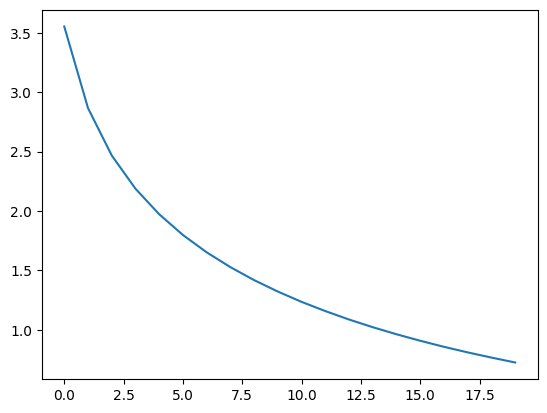

In [6]:
from torch.utils import data
import matplotlib.pyplot as plt

def train(net, train_features, train_labels, test_features, test_labels, epochs, lr, weight_decay, batch_size):

    train_dataloader = data.DataLoader(
        data.TensorDataset(train_features, train_labels), batch_size, shuffle=True
    )
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)

    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        train_iter = iter(train_dataloader)
        for x,y in train_iter:
            l = loss(net(x), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_loss.append(log_rmse(net(train_features), train_labels))
        if test_labels is not None:
            test_loss.append(log_rmse(net(test_features), test_labels))
    
    return train_loss, test_loss


res = train(net(), 
      train_features = train_features,
      train_labels = train_labels,
      test_features=test_features,
      test_labels=None,
      epochs=20,
      lr=5,
      weight_decay=0,
      batch_size=64)

plt.plot(res[0])

# 5.K则交叉验证

把训练数据分成K份，每次取1份作为验证集，取K-1份作为训练集

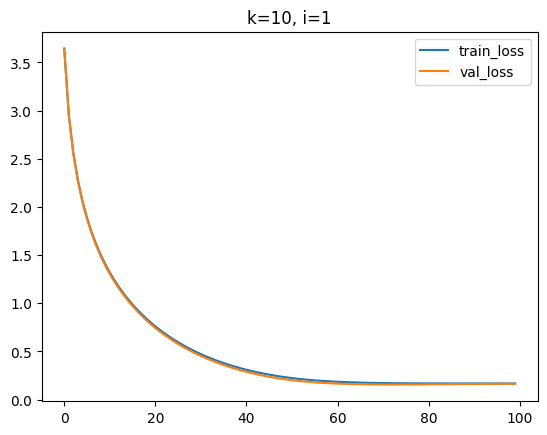

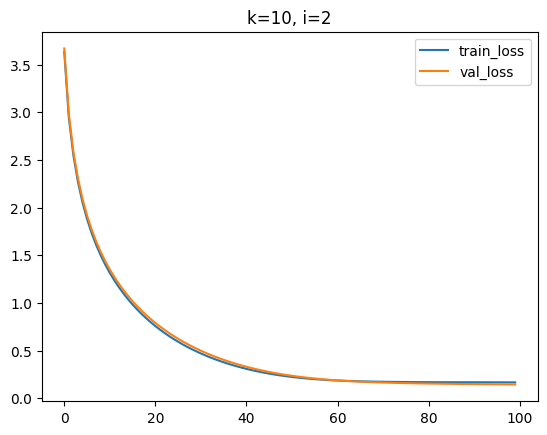

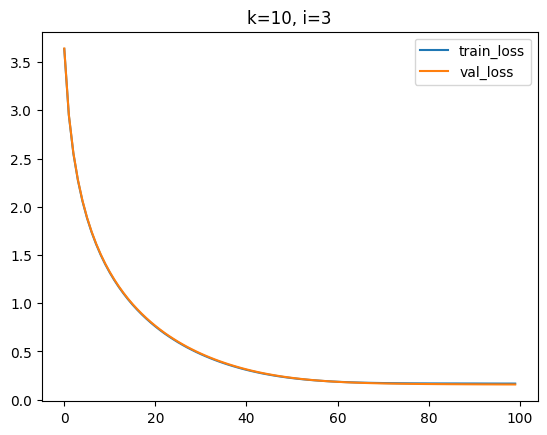

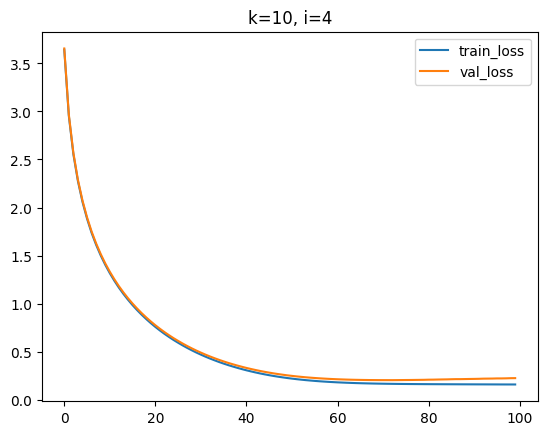

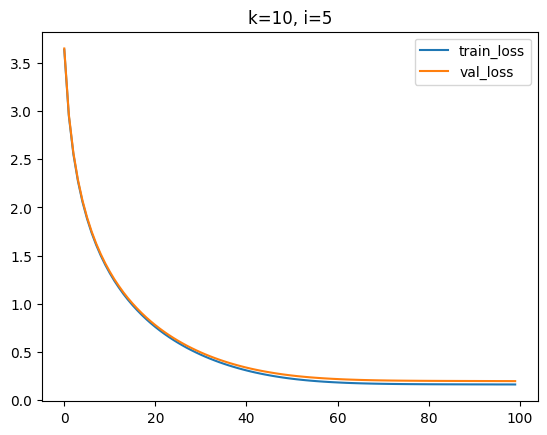

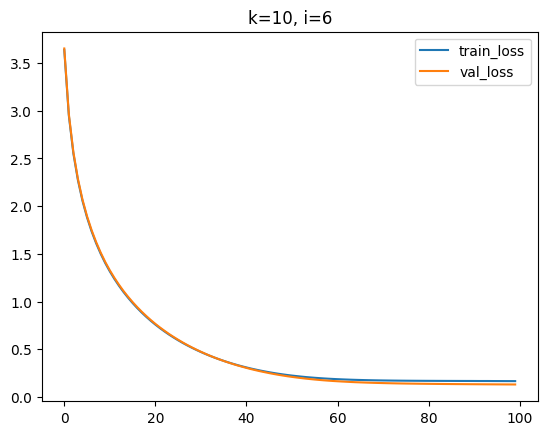

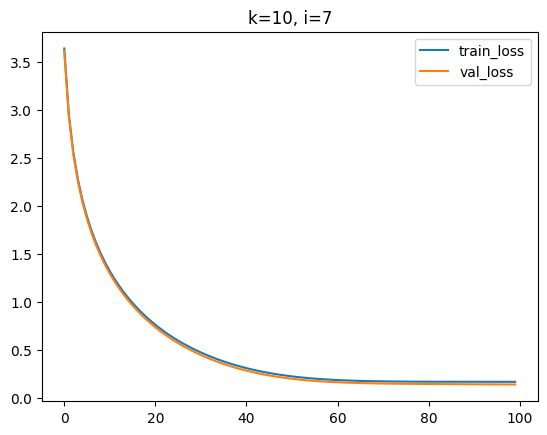

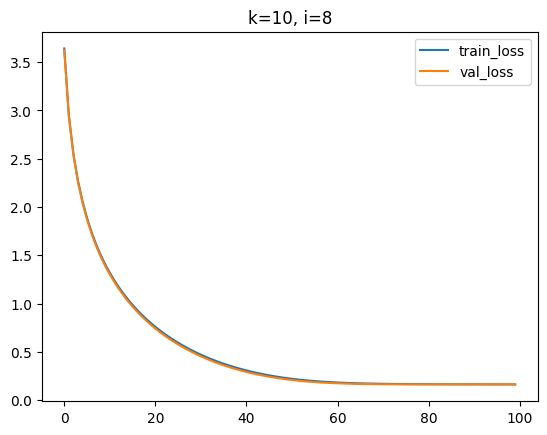

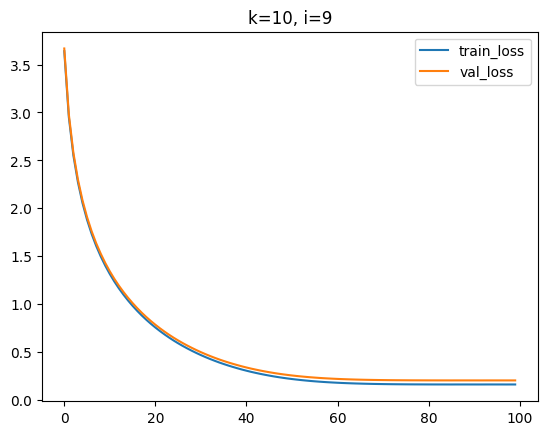

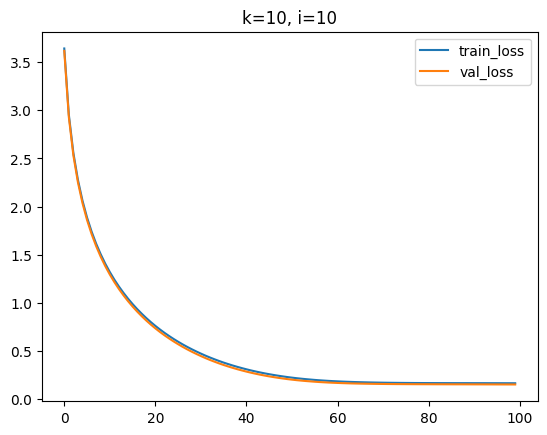

(0.16562972962856293, 0.15282997488975525)

In [11]:
def k_cross_train(k, data_features, data_labels, epochs, batch_size, lr, weight_decay):
    total_size = data_features.shape[0]
    each_size = total_size // k

    for i in range(k):
        record_train_loss = []
        record_val_loss = []

        # 获取训练集和验证集索引
        idx_train_part1 = slice(0, i*each_size)             # 如果超出，只会返回有效范围的数据
        idx_val = slice(i*each_size, (i+1)*each_size)
        idx_train_part2 = slice((i+1)*each_size, None)

        # 划分验证数据
        val_features =  data_features[idx_val,:]
        val_labels = data_labels[idx_val,:]

        # 划分训练数据
        train_features = torch.concat((data_features[idx_train_part1], data_features[idx_train_part2]))
        train_labels = torch.concat((data_labels[idx_train_part1], data_labels[idx_train_part2]))

        # 开始训练
        train_loss , val_loss = train(net(), train_features, train_labels, val_features, val_labels, epochs, lr, weight_decay, batch_size)

        # 保存损失
        record_train_loss.append(train_loss[-1])     # 把最后一个训练结果加到记录里去
        record_val_loss.append(val_loss[-1])

        # 画图
        plt.figure()
        plt.title(f'k={k}, i={i+1}')
        plt.plot(train_loss, label='train_loss')
        plt.plot(val_loss, label='val_loss')
        plt.legend()
        plt.show()

    return np.mean(record_train_loss), np.mean(record_val_loss)

k_cross_train(10, train_features, train_labels, epochs=100, batch_size=64, lr=5, weight_decay=0)